# 시계열 데이터 분석

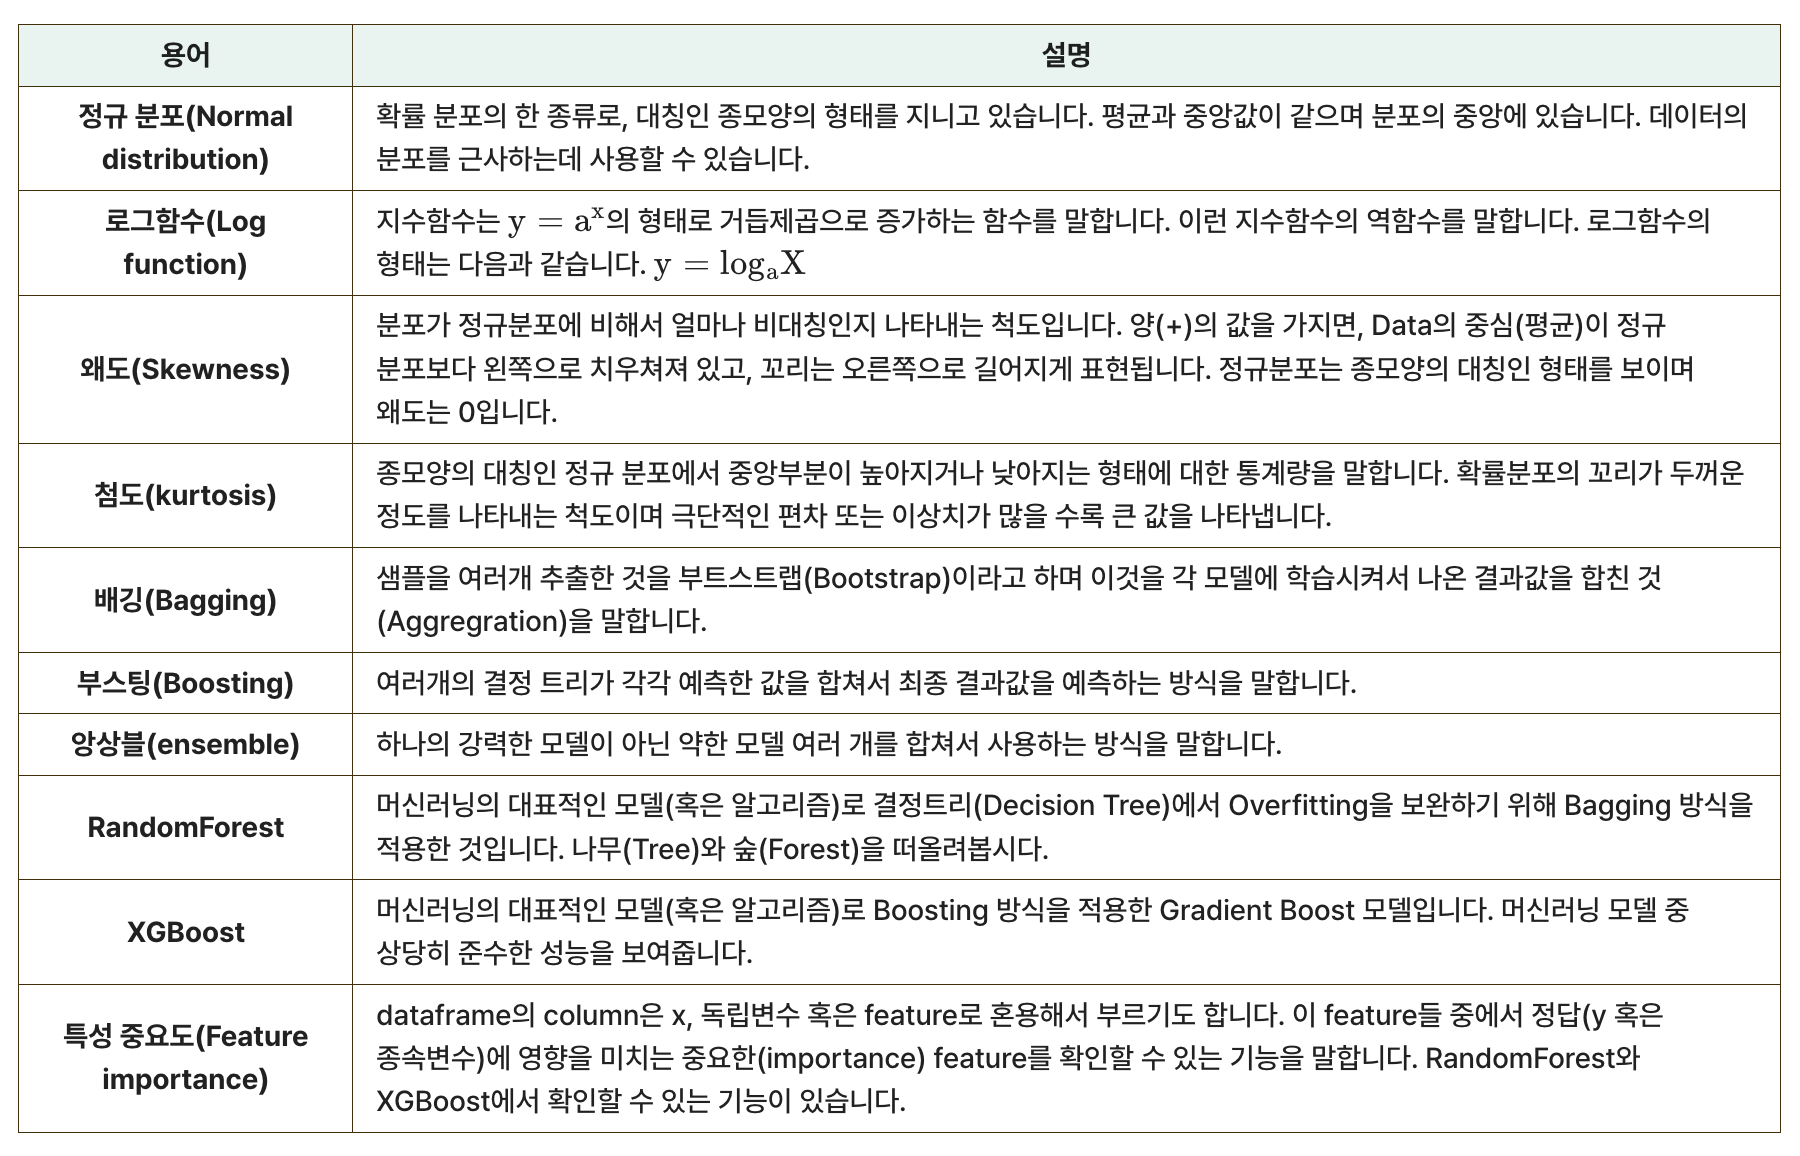

## 미니프로젝트의 목표!

Objective 1 : 비정상 데이터를 정상 데이터로 만들어봅시다!

Objective 2: 강의에 활용되었던 분류 모델의 성능을 높여봅시다!

## 강의에서 다룬 것 외에는 어떤 지식이 필요한가요?

#### Ensemble / Boosting / Bagging

* Ensemble : 하나의 데이터셋으로 여러 개의 모델을 학습시키고, 각각의 예측 결과를 결합하여 정확도를 향상시키는 기법입니다. Boosting, Bagging 등의 방법이 있습니다.

* Boosting : 여러 개의 모델을 순차적으로 연결해서 정확도를 향상시킵니다.

* Bagging : 학습 데이터셋에서 샘플을 랜덤하게 추출하여 하나의 모델을 학습시킵니다. 각각의 모델에 대해 "학습 샘플 추출 - 학습" 과정을 반복합니다.

#### 결정 트리(Decision Tree)

* 이진 분류기들을 나무가 가지를 뻗은 형태로 연결하여 여러 개의 클래스를 분류할 수 있도록 구성한 모델입니다. (참고: 결정트리 TensorFlow blog)

#### RandomForest / XGBoost의 이해와 활용법
* Random Forest : 여러 개의 결정 트리를 병렬적으로 학습시키고, 각각의 결과값을 결합하는 모델입니다. (bagging)

* XGBoost : 결정 트리를 순차적으로 연결하여 정확도를 향상시키는 모델입니다. (boosting)


아래의 순서대로 코드 실습이 진행됩니다. 코드를 실행하는 부분이 어떤 순서에 해당하는지 천천히 확인해보세요.

① 비정상 데이터를 정상 데이터로 만들기

② 분산을 일정하게 만들기 - log transformation

③ 차분을 통해 추세 제거하기

④ (추가) 계절 차분을 통해 계절성 제거하기

⑤ 검정을 통해 정상성 확인하기

⑥ 시계열 분류


    ⑥-1 : 데이터 다운로드 및 불러오기
    ⑥-2 : 데이터셋 확인(timeseries와 y 확인)
    ⑥-3 : 데이터셋 가공
    ⑥-4 : 데이터셋 나누기
    ⑥-5 : Feature extraction
    ⑥-6 : impute
    ⑥-7 : RandomForest 및 XGBoost 사용 및 score 확인
    ⑥-8 : XGBoost plot_importance 확인 및 시각화
    ⑥-9 : Classification report를 통한 검증 및 분석

### ① 비정상 데이터를 정상 데이터로 만들기
* 데이터가 있는 폴더 연결하기
* tsfresh 설치
* 런타임 재시작
* 필요한 라이브러리 불러오기
* 데이터 불러오기

In [1]:
!pip install tsfresh

In [ ]:
# 라이브러리 버전 충돌을 피하기 위해 런타임을 재시작합니다.
import os
os.kill(os.getpid(), 9)

In [1]:
# 라이브러리를 불러옵니다.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# air passengers 데이터를 불러옵니다.
ap = pd.read_csv('/aiffel/aiffel/time_series_basic/AirPassengers.csv')

# 'Month' column을 삭제합니다.
ap = ap.drop('Month',axis=1)
ap

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


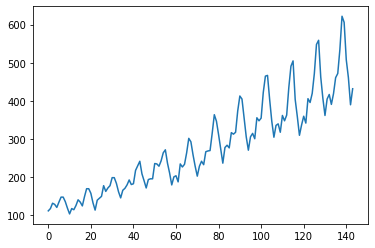

In [6]:
plt.figure()
plt.plot(ap)
plt.show()

### 분석 :
점점 증가하는 추세와 분산으로 인해서 완벽히 비정상 데이터임을 알 수 있다.

분산을 줄이고, 증가하는 추세를 줄인다면 정상 시계열을 얻을 수 있을 것이다.

### ② 분산을 일정하게 만들기 - log transformation
* log transformation을 하는 이유는 다음과 같습니다.

    * 큰 수를 같은비율의 작은 수로 만들 수 있습니다.
    * 복잡한 계산을 쉽게 만듭니다.
    * 왜도(skewness)와 첨도(kurtosis)를 줄여서 데이터 분석 시 의미있는 결과를 도출하기 위한 것입니다.

In [9]:
# np.log를 통해서 log transformation
log_transformed = np.log(ap)
log_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


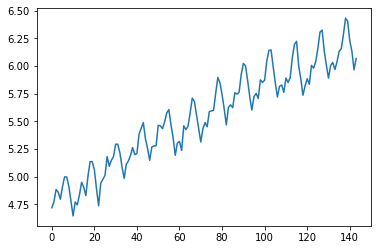

In [10]:
# 분산이 일정해진 것을 눈으로 확인할 수 있습니다.
plt.figure()
plt.plot(log_transformed)
plt.show()

### 분석:
증가하던 분산을 통제함

### ③ 차분을 통해 추세 제거하기

In [11]:
# diff() 함수를 통해 간단하게 차분을 수행할 수 있습니다.
diffed = log_transformed.diff()[1:]
diffed

,#Passengers
1,0.052186
2,0.112117
3,-0.022990
4,-0.064022
5,0.109484
...,...
139,-0.026060
140,-0.176399
141,-0.097083
142,-0.167251


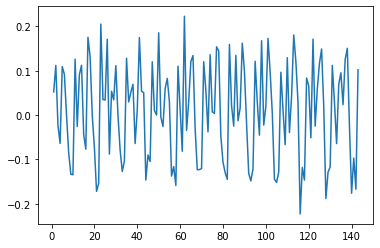

In [13]:
# 커지는 분산과 증가하는 추세를 제거한 air passengers 데이터를 얻을 수 있습니다.
plt.figure()
plt.plot(diffed)
plt.show()

### 분석:
(주의) diff를 사용하면 데이테가 짧아짐. 따라서 데이터를 잘라서 쓰거나 차분하고 없어진 데이터(Nan값)을 꼭 제거하고 활용해야함.

결과적으로 평균이 0이고, 분산도 커지지 않는 데이터를 얻을 수 있음.

### ④ (추가) 계절 차분을 통해 계절성 제거하기

AirPassengers 데이터는 12개월을 주기로 하는 계절성이 포함되어 있습니다. 

이런 경우엔 계절 차분을 통해서 계절성을 데이터에서 제거할 수 있습니다.

In [15]:
# diff에 12라는 값을 넣어주면 주기를 12로 하는 계절 차분을 수행할 수 있습니다.
seasonally_diffed = diffed.diff(12)
seasonally_diffed

,#Passengers
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
139,-0.045934
140,0.012024
141,0.031830
142,-0.050082


In [17]:
# 차분을 하면 데이터가 짧아지기 때문에 빈칸을 제거해야 합니다.
seasonally_diffed.dropna(inplace = True)
seasonally_diffed

,#Passengers
13,0.039164
14,0.000361
15,-0.020496
16,-0.012939
17,0.066148
...,...
139,-0.045934
140,0.012024
141,0.031830
142,-0.050082


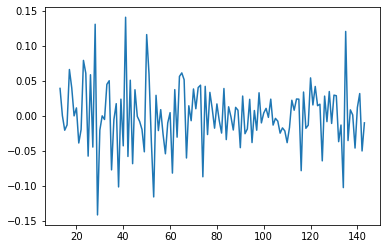

In [18]:
# 아래와 같은 데이터를 얻을 수 있습니다.
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

### ⑤ 검정을 통해 정상성 확인하기

* adfuller : Python에서 statsmodels을 통해 ADF(Augmented Dickey-Fuller) Test를 할 수 있습니다. 앞서 Classification report를 통해 Logistic Regression 모델을 검증한 것과 마찬가지로 시계열 데이터를 통계 분석하고 검증할 때 사용합니다. adfuller를 사용하면 대표적으로 다음과 같은 값을 얻을 수 있습니다.

    * adf(단위근 검정, Augmented Dickey Fuller) : 정상성을 확인하기 위한 단위근 검정방법
    * p-value(유의 검정) : 관찰된 데이터가 귀무가설이 맞다면 통계값 1이 실제로 관측된 값 이상일 확률
    * usedlag : 사용된 시차의 수
    * nobs : ADF 회귀 및 임계값 계산에 사용된 관측치의 수
    * critical values(임계값) : 1%, 5% 및 10% 수준에서 테스트 통계에 대한 임계값
    * icbest : 0, 1, …, maxlag 값 중 lag 길이를 자동으로 결정할 때 autolag를 사용하며 이때 autolag를 none으로 지정할 수 있는데 none으로 지정하지 않는 경우 최대화된 정보 기준

In [19]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x): # adf검정을 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output이 나옵니다.
    print('ADF statistics')
    print(stat) # ADF 검정 통계량입니다.
    print('P-value')
    print(p_value) # P-value입니다.

In [20]:
# 계절차분까지 수행한 데이터로 adf 테스트를 수행합니다.
adf_test(seasonally_diffed)

ADF statistics
-4.4433249418311425
P-value
0.00024859123113838495


### 분석 : 
유의수준 0.01에서 단위근이 존재한다는 귀무가설을 기각하고 시계열은 정상적이다라는 대립가설은 채택할 수 있다.

### ⑥ 시계열 분류

In [21]:
# ⑥-1 : 데이터 다운로드 및 불러오기
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

# robot exection failures 데이터를 불러옵니다.
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [22]:
# ⑥-2 : 데이터셋 확인(timeseries와 y 확인)
timeseries # id, time을 제외하고 6개 column의 X변수가 나타납니다.

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [23]:
y # true/false가 제시되어 있습니다.

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [25]:
# ⑥-3 : 데이터셋 가공
def custom_classification_split(x,y,test_size=0.3): # 수업 때 보았던 custom split 함수
    
    num_true = int(y.sum()*test_size)
    num_false = int((len(y)-y.sum())*test_size)
    
    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()
    
    
    y_train = y.drop(id_list)                            # y에서 id_list를 drop합니다.  
    y_test = y.iloc[id_list].sort_index()                # 20~39, 2~7이 합쳐진 리스트를 정렬합니다.
    X_train = timeseries[~timeseries['id'].isin(id_list)] # 대괄호 안에 있는 timeseries의 id와 id_list가 일치하는 것만 사용하고 물결표시는 안에 조건이 포함되어 있지 않는것만 사용하는 것입니다.
    X_test = timeseries[timeseries['id'].isin(id_list)]   # timeseries의 id와 id_list가 일치하는 것만 사용해서 timeseries에 적용
    
    
    
    return X_train, y_train, X_test, y_test

In [26]:
# ⑥-4 : 데이터셋 나누기
# test set의 비율을 0.25로 지정해주세요.
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size = 0.25)

EfficientParameters는 큰 계산비용이 필요한 calculator를 제외하고 가능한 모든 특징을 생성합니다.

In [27]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters()

In [28]:
# ⑥-5 : Feature extraction
comprehensive_features_train = extract_features(
                                    X_train, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 402/402 [00:17<00:00, 23.42it/s]


In [29]:
comprehensive_features_test = extract_features(
                                    X_test, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 126/126 [00:04<00:00, 25.55it/s]


impute를 통해 간단히 데이터를 전처리합니다.

In [30]:
# ⑥-6 : impute
impute(comprehensive_features_train)

/opt/conda/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,0.0,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,0.0,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
9,1.0,0.0,0.0,1.0,-10.0,24.0,1.428571,0.000000,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.479133,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
10,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,0.000000,-1.0,...,0.937285,1.213008,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1.0,-1073.0,96833.0,7.142857,-5.428571,-0.038462,-98.0,...,0.735622,0.735622,1.386294,1.585771,2.253858,2.397895,2.302585,2.197225,0.0,24.285714
85,1.0,0.0,1.0,1.0,143.0,1683.0,1.357143,1.071429,0.076923,8.0,...,0.735622,0.735622,1.667462,1.332245,1.589027,1.893788,2.163956,2.197225,0.0,5.571429
86,1.0,0.0,0.0,0.0,961.0,83497.0,9.071429,9.071429,0.807692,52.0,...,0.735622,1.073543,1.732868,0.687092,0.983088,1.159589,1.227529,1.303092,0.0,9.285714
87,1.0,1.0,0.0,1.0,4509.0,1405437.0,12.928571,12.214286,-1.038462,338.0,...,0.735622,0.735622,1.386294,0.535961,0.836988,1.159589,1.497866,1.581094,0.0,40.285714


In [31]:
impute(comprehensive_features_test)

/opt/conda/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,0.0,3.714286


첫번째로 Random Forest 모델을 활용해보겠습니다.






In [32]:
# ⑥-7 : RandomForest 사용 및 score 확인
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3)

rf_clf.fit(comprehensive_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [34]:
# test셋에 적합해본 결과 약 0.80의 정확도를 보입니다.
rf_clf.score(comprehensive_features_test, y_test)

0.8095238095238095

두번째로 XGBoost를 활용하겠습니다.






In [36]:
# ⑥-7 : XGBoost 사용 및 score 확인
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)

# XGBoost 모델을 학습시킵니다.
xgb_clf.fit(comprehensive_features_train, y_train)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:19:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
# XGBoost 모델의 score를 확인합니다.
xgb_clf.score(comprehensive_features_test, y_test)

1.0

### 분석:
XGBoost를 활용하니 완벽하게 분류를 해낼 수 있다.

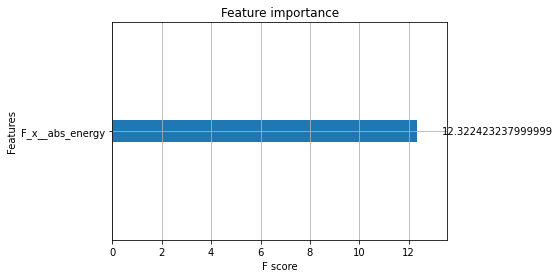

In [38]:
# ⑥-8 : XGBoost plot_importance 확인 및 시각화
# plot_importance를 통해 어떤 변수(특징)가 가장 유의미한지 확인합니다.
xgb.plot_importance(xgb_clf, importance_type = 'gain')
plt.show()

In [39]:
sum(xgb_clf.feature_importances_ != 0) # Fx 값의 abs_energy 특징만의 유의미함

1

결국 고장 유무를 판별하는 기준은 F_X_abs_energy라는 특징 하나였습니다!






In [40]:
# ⑥-9 : Classification report를 통한 검증 및 분석
from sklearn.metrics import classification_report

classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21}}

## 마무리

classification report를 통해 지표에서 설명하는 통계적인 수치가 각각 무엇인지 설명하고 이해하는 시간을 가져보도록 합시다. 

classification report에 나타나있는 true와 false에서 precision, recall, f1-score, support가 의미하는 것은 무엇일까요?

### Answer : 
TP = True Positive, 실제 값이 True이고 예측도 True였던 경우의 수

FP = False Positive, 실제 값이 False였는데 예측이 True였던 경우의 수

FN = False Negative, 실제 값이 False였는데 예측이 True였던 경우의 수

TN = True Positive, 실제 값이 False이고 예측도 False였던 경우의 수

1) Precision = 정밀도

    양성 클래스라고 예측한 샘플(TP+FP) 중 실제로 양성 클래스에 속하는 샘플(TP) 샘플 수의 비율.

    높을수록 좋다. '예측값'을 기준으로 한 '정답인 예측값'의 비율로 생각하면 쉽다.

* $precision=\frac{TP}{TP\ +\ FP}$

2) Recall = 재현율

    실제 양성 클래스에 속한 샘플(TP+FN) 중 양성 클래스라고 예측한 샘플(TP) 샘플 수의 비율.

    역시 높을수록 좋다. '실제 값'을 기준으로 한 '정답인 예측값'의 비율로 생각하면 쉽다.

* $recall=\frac{TP}{TP+FN}$

3) Accuracy = 정확도

    전체 샘플 중 맞게 예측한 샘플 수의 비율. 역시 높을수록 좋다.

* $accuracy=\frac{TP+TN}{TN+TP+FN+FP}$

4) F1-score

    precision과 recall의 가중 조화평균(weight harmonic average)을 F-score라 한다.

* $\combi{F}_{\beta }=(1+\combi{β}^2)(precision\times recall)/(\combi{β}^2precision+recall)$

    이때 정밀도에 주어지는 가중치를 bate라고 하는데 이 beta가 1인 경우를 F1-score라고 한다.

    $\combi{F}_1=(1+\combi{1}^2)(precision\times recall)/(\combi{1}^2precision+recall)$
    
5) support

각 라벨의 실제 샘플 개수이다.

[출처] classification_report로 평가 지표 확인하기|작성자 6시 내 교양